In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

#### corin's attempts to fit random forest to data

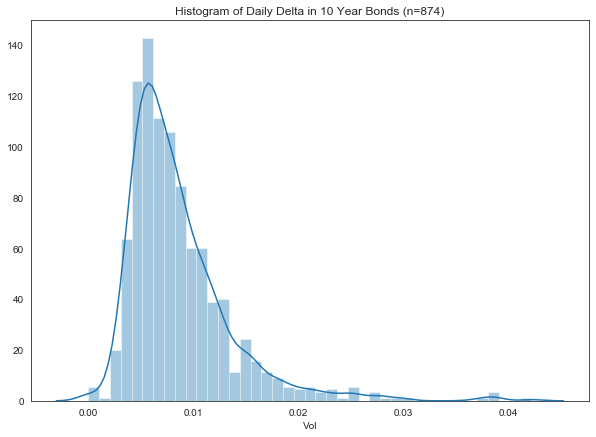

In [2]:
bonds_10 = pd.read_csv('../bonds/adjusted^TNX.csv')
bonds_10['Vol'] = (bonds_10['High'] - bonds_10['Low']) / (bonds_10['High'] + bonds_10['Low'])
#print(bonds_10.head(10))

bonds_30 = pd.read_csv('../bonds/adjusted^TYX.csv')
bonds_30['Vol'] = (bonds_30['High'] - bonds_30['Low']) / (bonds_30['High'] + bonds_30['Low'])
#print(bonds_30.head(10))

fig = plt.figure(figsize=(10,7))
sns.distplot(bonds_10['Vol'])
plt.title(f'Histogram of Daily Delta in 10 Year Bonds (n={len(bonds_10)})')

plt.show()

In [22]:
stocks_cn = pd.read_csv('../stocks/log_adj_chinese_combo.csv')


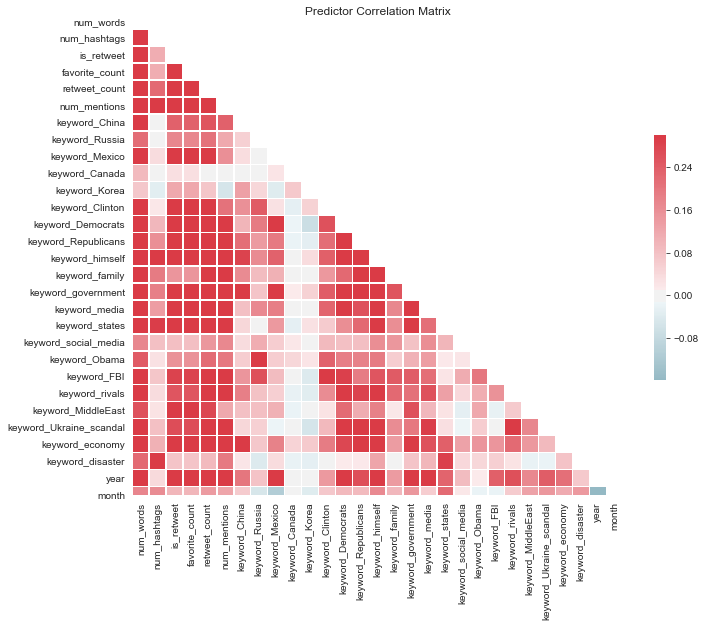

In [53]:
predictors = pd.read_csv('../tweets/cleaned_tweets_by_day')

#### so we can quickly pull out the desired columns later
pred_cols = predictors.columns.values
pred_cols = list(filter(lambda a: not re.match("Unnamed", a), pred_cols))
pred_cols = list(filter(lambda a: not re.match("Date", a), pred_cols))
#pred_cols = list(filter(lambda a: not re.match("year", a), pred_cols))
#pred_cols = list(filter(lambda a: not re.match("month", a), pred_cols))
pred_cols = list(filter(lambda a: not re.match("day", a), pred_cols))


if 0:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,7))

    for ax in np.ravel(axes):
        ax.get_yaxis().set_visible(False)

    sns.distplot(predictors['num_hashtags'], ax=axes[0][0])
    sns.distplot(predictors['retweet_count'], ax=axes[0][1])
    sns.distplot(predictors['favorite_count'], ax=axes[0][2])
    sns.distplot(predictors['keyword_himself'], ax=axes[1][0])
    sns.distplot(predictors['keyword_economy'], ax=axes[1][1])
    sns.distplot(predictors['num_mentions'], ax=axes[1][2])
    fig.suptitle("Histograms of Various Response Variables", fontsize=14)
    plt.tight_layout
    plt.show()

#print("average daily keywords:\n")
#for keyword in list(filter(lambda a: re.match("keyword", a), pred_cols)):
#    print(f"{keyword:30s}: {np.mean(predictors[keyword]):.3f}")

corr = predictors[pred_cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Predictor Correlation Matrix')
plt.show()

In [48]:
pred_bonds_10 = pd.merge(left=bonds_10, right=predictors, on='Date') # default is INNER join which is what we want
#### now these have the same indices!

X, Xt, y, yt = train_test_split(pred_bonds_10[pred_cols], pred_bonds_10['Vol'], test_size=0.3, random_state=42)

In [49]:
rf_b = RandomForestRegressor(n_estimators=50,max_features=0.33, max_depth=15, min_samples_leaf=5, random_state=42).fit(X, y)
print(f"train is {rf_b.score(X,y):.3f}")
print(f"test is  {rf_b.score(Xt,yt):.3f}")

train is 0.582
test is  0.301


In [50]:
pred_stocks_cn = pd.merge(left=stocks_cn, right=predictors, on='Date') # default is INNER join which is what we want
#### now these have the same indices!

X, Xt, y, yt = train_test_split(pred_stocks_cn[pred_cols], pred_stocks_cn['combined'], test_size=0.3, random_state=42)

In [52]:
rf_s = RandomForestRegressor(n_estimators=50,max_features=0.33, max_depth=10, min_samples_leaf=5, random_state=42).fit(X, y)
print(f"train is {rf_s.score(X,y):.3f}")
print(f"test is  {rf_s.score(Xt,yt):.3f}")
# wow!

train is 0.813
test is  0.722
